In [25]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np

import pymc3 as pm 
from pymc3 import *

from sklearn.linear_model import LinearRegression 

%config InlineBackend.figure_format = 'retina'
#az.style.use('arviz-darkgrid')


In [26]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 5, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.4, size=size)

data = dict(x=x, y=y)
df = pd.DataFrame(data=data)

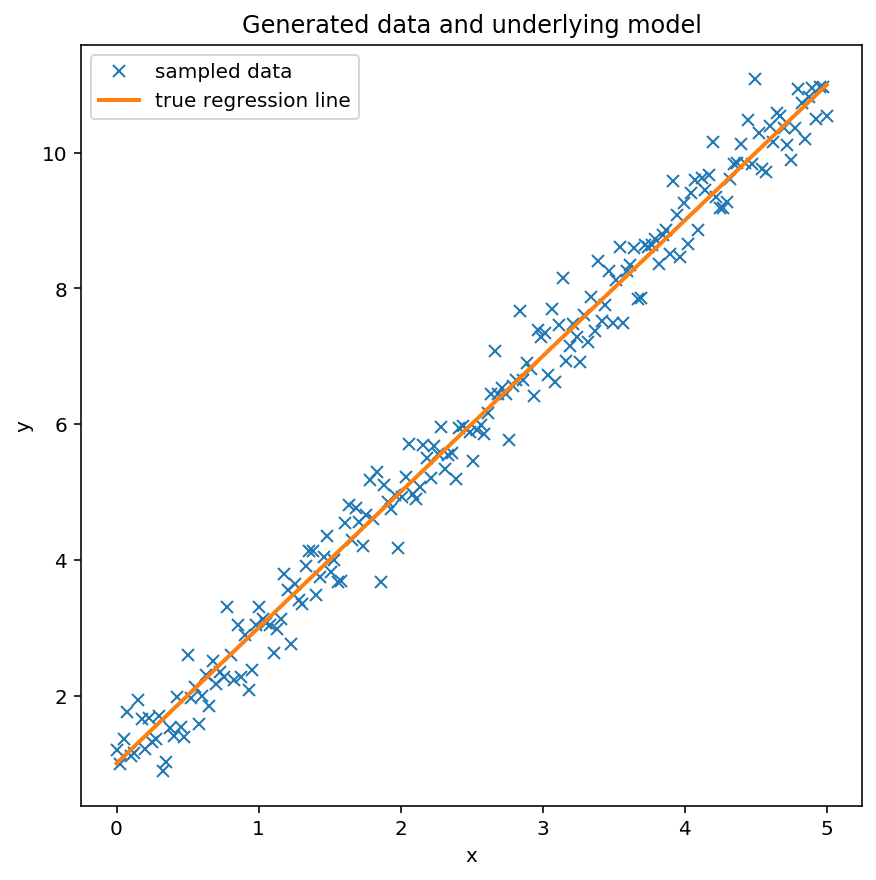

In [27]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(df['x'], y, 'x', label='sampled data')
ax.plot(df['x'], true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [28]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

X, y = df['x'].to_numpy(), df['y'].to_numpy()
sk = KFold(n_splits=5)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])


cross_scores = list()
for train_index, test_index in sk.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pipeline.fit(X_train.reshape(-1, 1), y_train)
    cross_scores.append(pipeline.score(X_test.reshape(-1, 1), y_test))

print(f"mean_score:{np.mean(cross_scores)}, std:{np.std(cross_scores)}" )

mean_score:0.6828263664872217, std:0.054063556742187706


In [29]:
print(f"coefficients: {pipeline.steps[1][1].coef_[0]}, intercept:{pipeline.steps[1][1].intercept_}")

coefficients: 2.3442168842571567, intercept:4.967934170775123


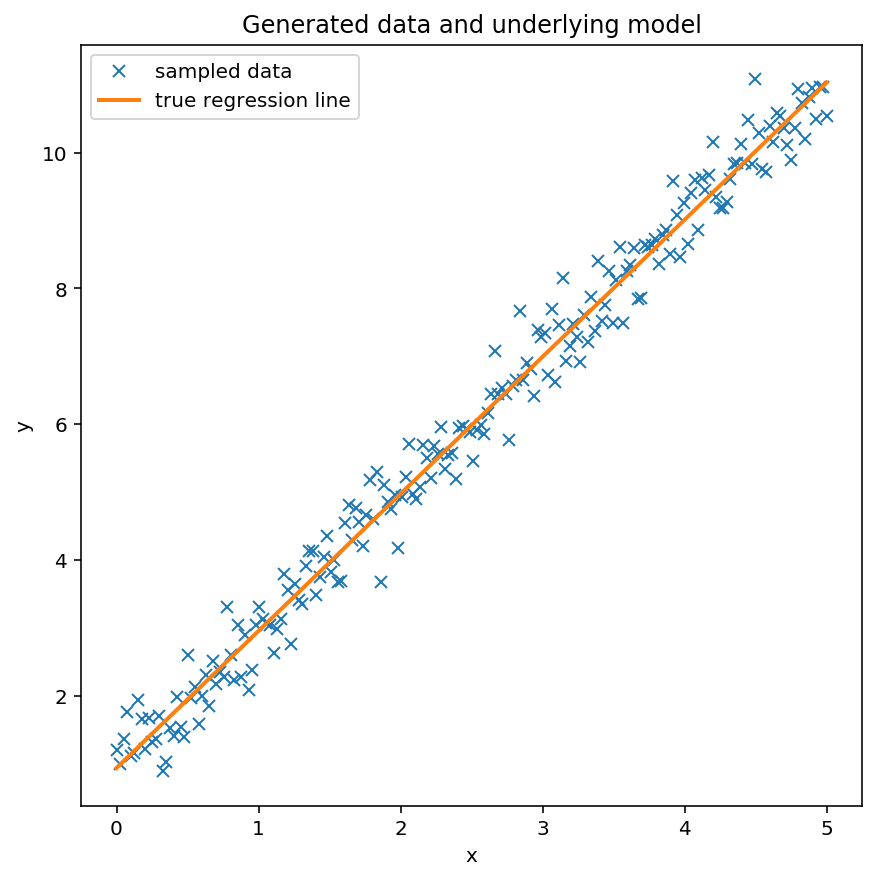

In [30]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(df['x'], y, 'x', label='sampled data')
ax.plot(df['x'], pipeline.predict(X.reshape(-1, 1)), label='true regression line', lw=2.)
plt.legend(loc=0);

In [34]:
with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy('sigma', beta=10, testval=1.)
    intercept = Normal('Intercept', 1, sigma=5)
    x_coeff = Normal('x', 2, sigma=0.7)

    # Define likelihood
    likelihood = Normal('y', mu=intercept + x_coeff * x,
                        sigma=sigma, observed=y)

    # Inference!
    trace = sample(10000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.


<Figure size 504x504 with 0 Axes>

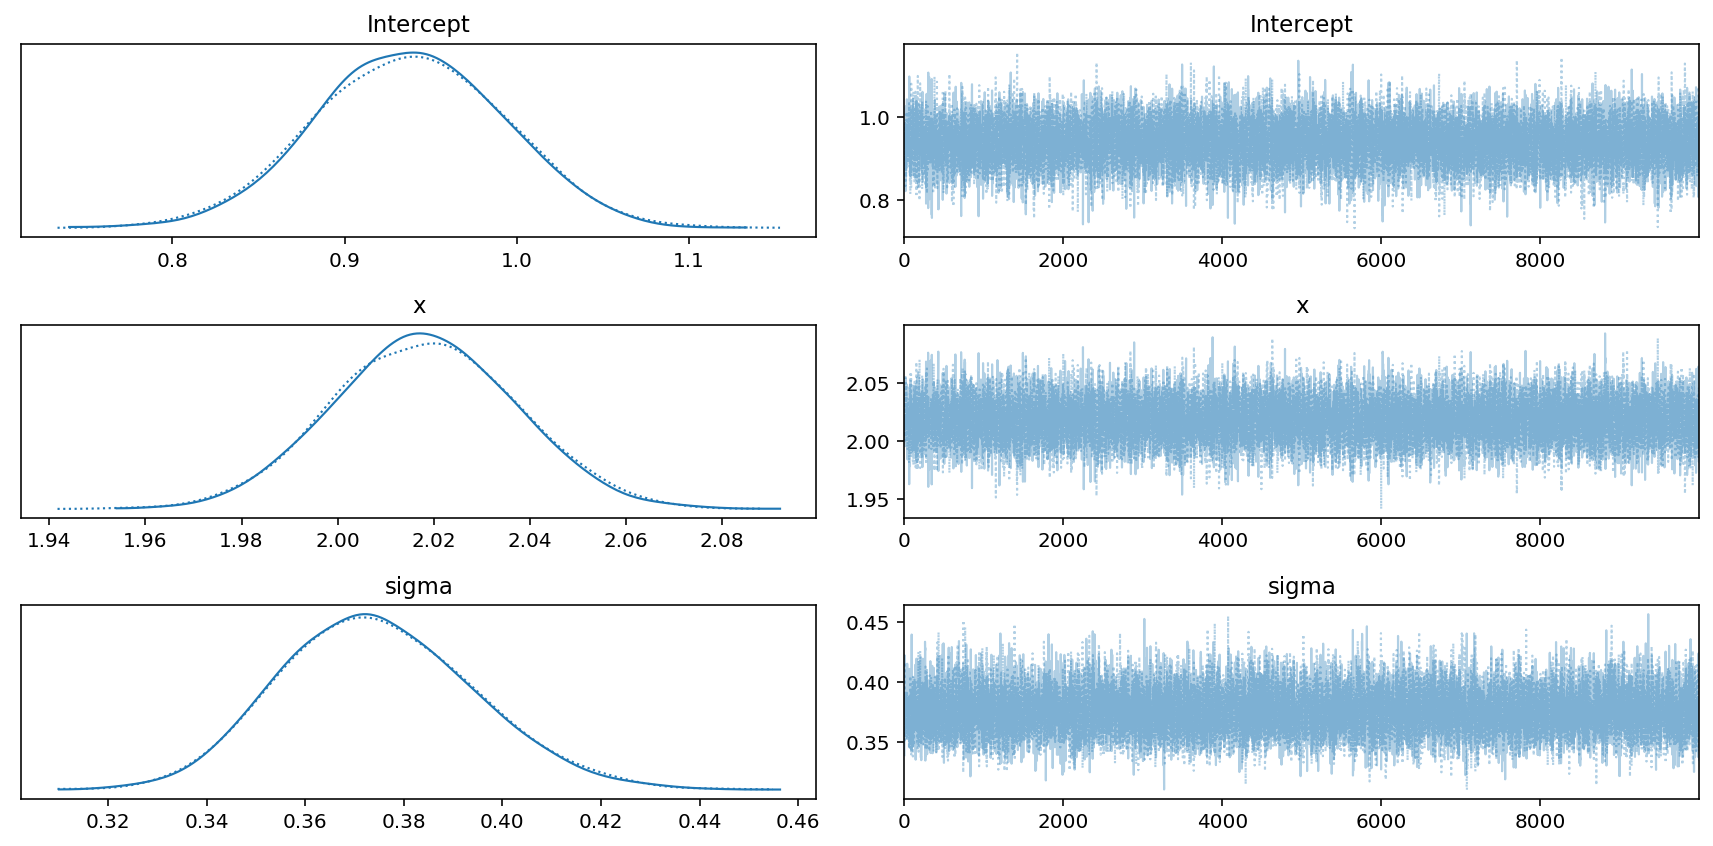

In [35]:
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout();

In [36]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace, samples=100, var_names=["Intercept", "x", "sigma"], random_seed=42
    )

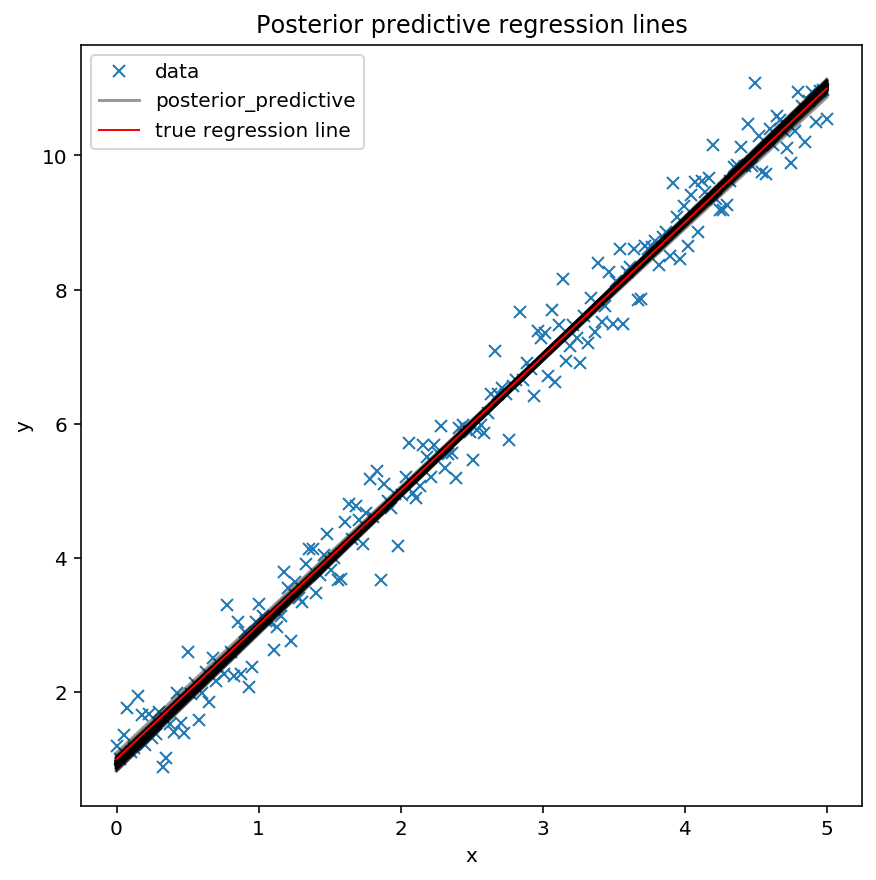

In [40]:
plt.figure(figsize=(7, 7))
plt.plot(df['x'], df['y'], 'x', label='data')

for a, b in zip(ppc["Intercept"], ppc["x"]):
    y = a + b * x
    plt.plot(x, y, c="k", alpha=0.4)
plt.plot(x, y, c="k", label='posterior_predictive', alpha=0.4)

plt.plot(x, true_regression_line, label='true regression line', lw=1., c='r')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

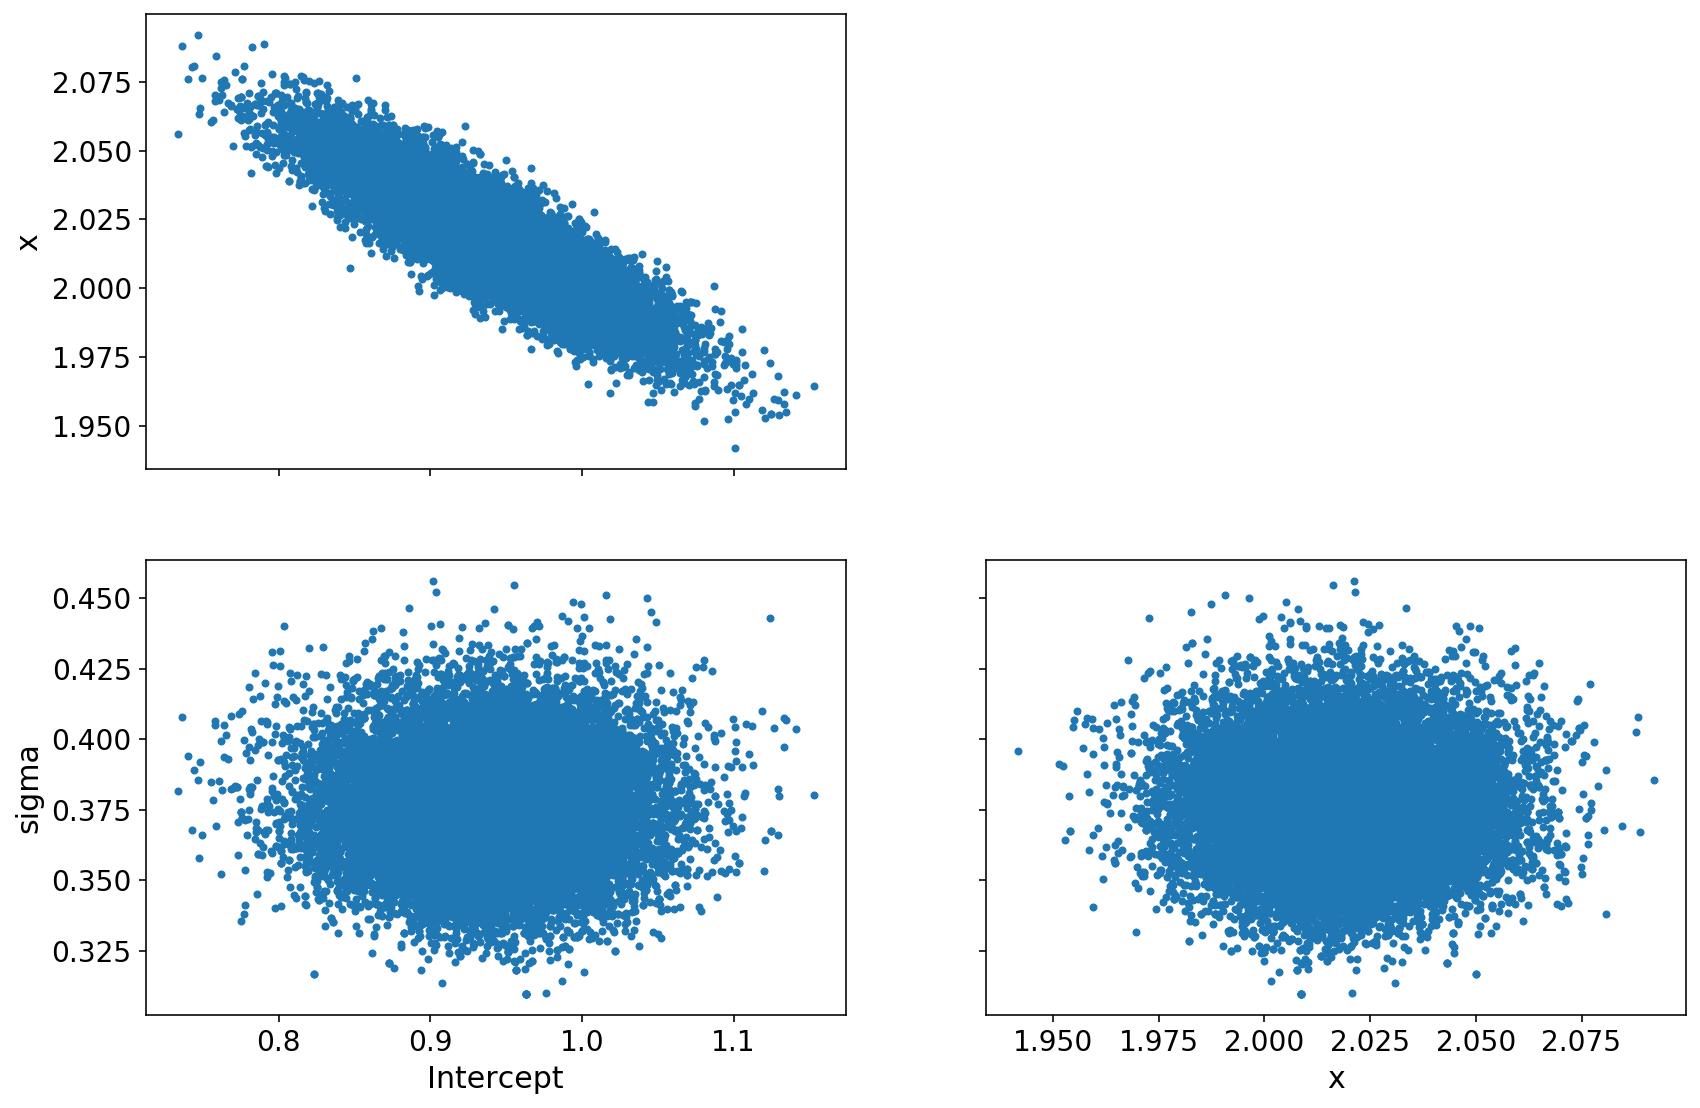

In [41]:
pm.pairplot(trace, var_names=["Intercept", "x", "sigma"], divergences=True);